In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


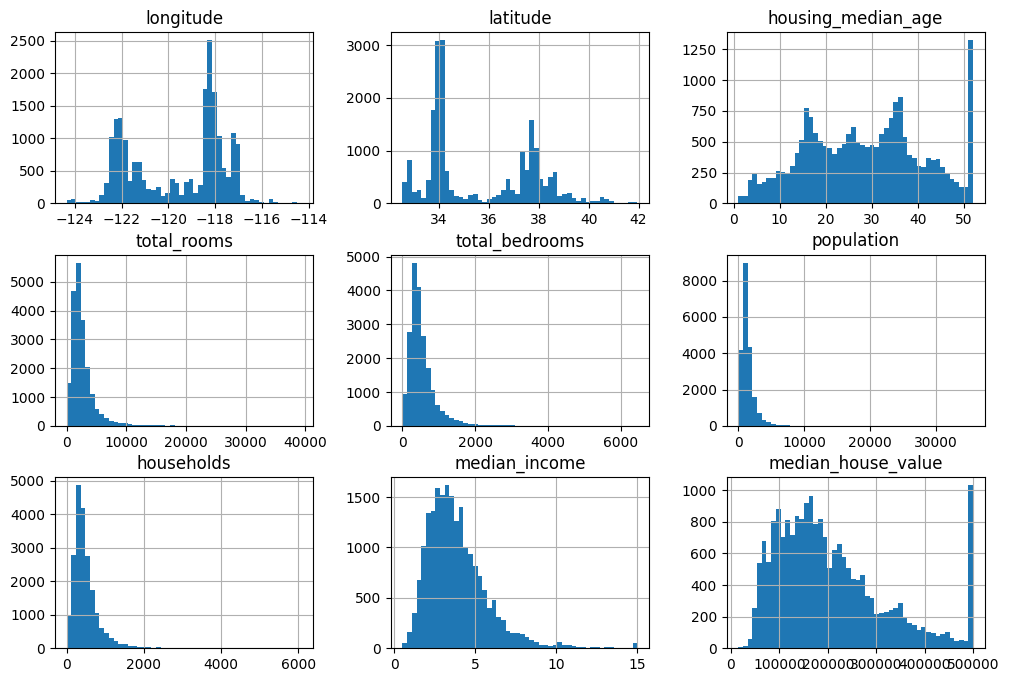

In [6]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [7]:
import numpy as np

def shuffle_and_split_data( data, test_ratio ):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]


In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [9]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index() #adds an index column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [11]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

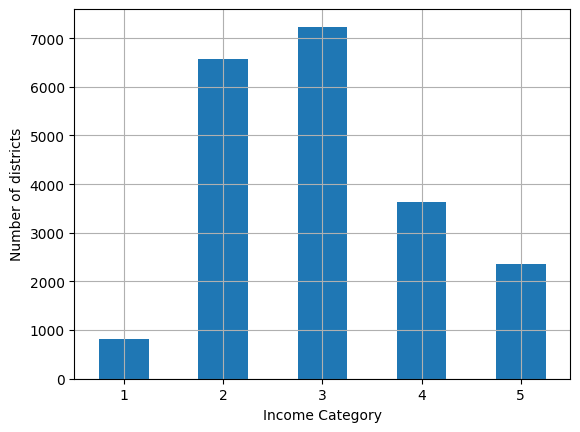

In [14]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state= 42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [16]:
strat_train_set, strat_test_set = strat_splits[0]

In [17]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size = 0.2, stratify=housing["income_cat"], random_state=42
)

In [18]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [19]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [20]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [21]:
housing = strat_train_set.copy()

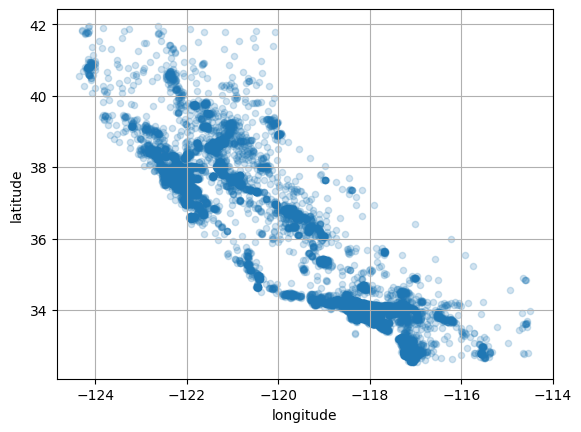

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             alpha=0.2)
plt.show()

<Axes: xlabel='longitude', ylabel='latitude'>

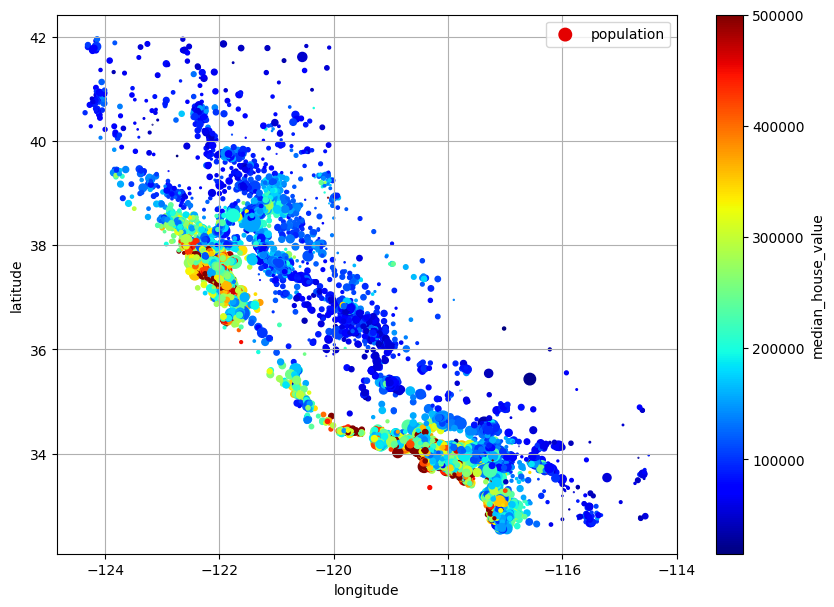

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

In [24]:
corr_matrix = housing.select_dtypes(include=[np.number])

In [25]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0


In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

10134    500001.0
2237     500001.0
3070     500001.0
6684     500001.0
16333    500001.0
           ...   
1504      17500.0
12793     14999.0
5444      14999.0
13309     14999.0
15088     14999.0
Name: median_house_value, Length: 16512, dtype: float64

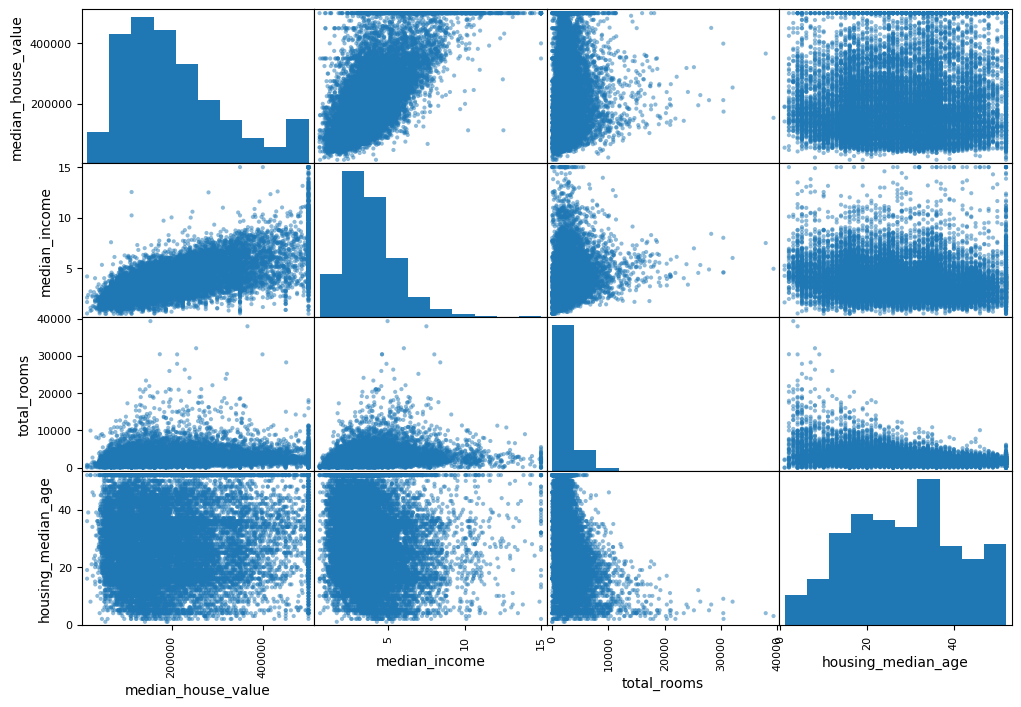

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income",
              "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()


In [28]:
print(housing.dtypes)

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


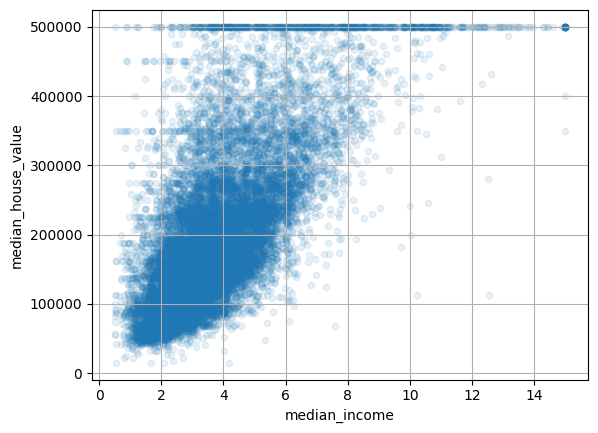

In [29]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True,
             alpha=0.1)
plt.show()

In [30]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [31]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] /housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [32]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [33]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [36]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [37]:
housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [38]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [39]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [40]:
X = imputer.transform(housing_num)
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]], shape=(16512, 8))

In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [42]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [44]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [45]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [47]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [48]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [49]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
df_test = pd.DataFrame({"ocean_proximity": ['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [51]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [52]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [53]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [54]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1 )

In [55]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [56]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

In [57]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    LinearRegression(), transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [58]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func="np.exp")
log_pop = log_transformer.transform(housing[["population"]])

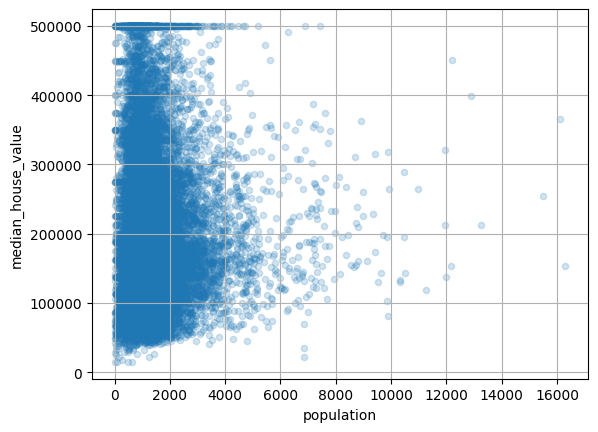

In [59]:
strat_train_set.plot(kind="scatter", x="population", y="median_house_value", grid=True, alpha=0.2)
plt.show()

In [60]:
strat_train_set.info(
)

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [61]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]],gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [62]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):
    self.with_mean = with_mean

  def fit(self, X, y=None):
    X=check_array(X)
    self.mean_ = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_feature_in_ = X.shape[1]

    return self

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
      return X / self.scale_

In [64]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
      self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
      self.kmeans_.fit(X, sample_weight=sample_weight)
      return self

  def transform(self, X):
      return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
      return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [65]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

In [66]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

<Axes: xlabel='longitude', ylabel='latitude'>

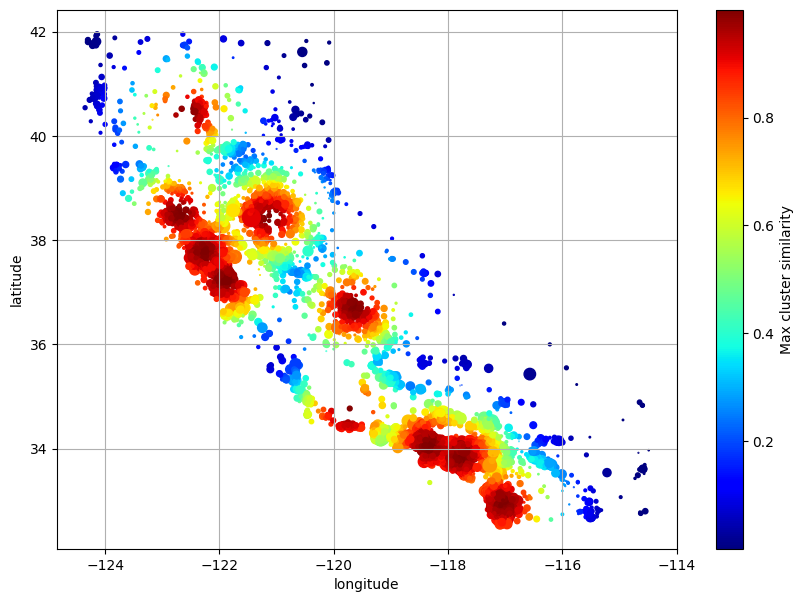

In [67]:
housing["Max cluster similarity"] = similarities.max(axis=1)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, c="Max cluster similarity",
             cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))

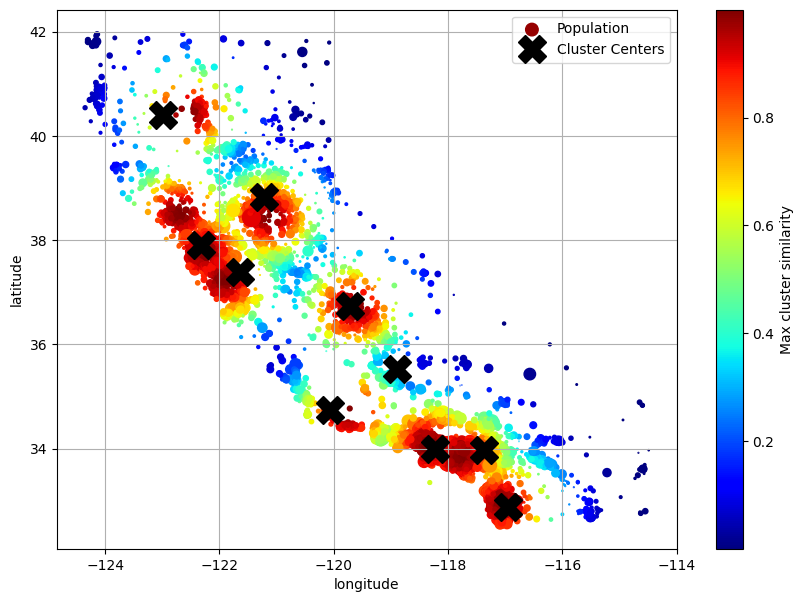

In [68]:
# housing["Max cluster similarity"] = similarities.max(axis=1)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, c="Max cluster similarity",
             cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7),
             label="Population")
cluster_simil.fit(housing[["latitude", "longitude"]]) # Fit the ClusterSimilarity object
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster Centers")
plt.legend(loc="upper right")
plt.show()

In [69]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

In [70]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler())

In [71]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [72]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [73]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age",
               "total_rooms", "total_bedrooms", "population",
               "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [74]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [75]:
housing_prepared = preprocessing.fit_transform(housing)


In [76]:
housing_df = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)

In [77]:
housing_df.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__Max cluster similarity,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.633604,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.687100,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,-0.862628,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,-0.980526,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.216201,0.0,0.0,0.0,0.0,1.0


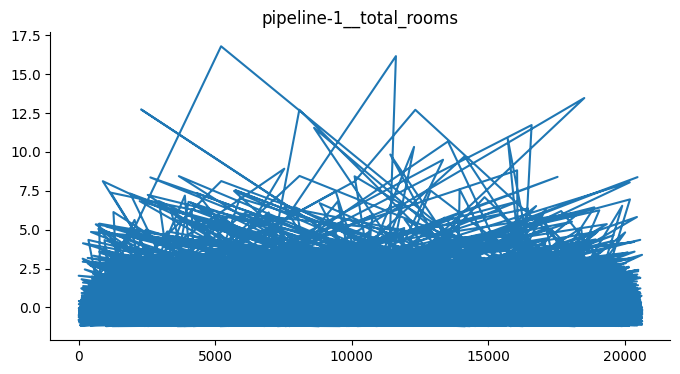

In [78]:
# @title pipeline-1__total_rooms

from matplotlib import pyplot as plt
housing_df['pipeline-1__total_rooms'].plot(kind='line', figsize=(8, 4), title='pipeline-1__total_rooms')
plt.gca().spines[['top', 'right']].set_visible(False)

In [79]:
from sklearn.pipeline import Pipeline

def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, features_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler()
  )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

# cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42) # Moved to be part of the pipeline

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population","households", "median_income"]),
    ("geo", ClusterSimilarity(n_clusters=10, gamma=1, random_state=42), ["latitude", "longitude"]), # Included ClusterSimilarity here
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

In [80]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [81]:
housing_prepared_new = preprocessing.fit_transform(housing)
housing_prepared_new.shape

(16512, 25)

In [82]:
preprocessing.get_feature_names_out()[24]

'remainder__Max cluster similarity'

In [83]:
housing_prepared = np.delete(housing_prepared, 24, axis=1) # This line is no longer needed

In [84]:
housing_prepared.shape

(16512, 24)

In [85]:
# housing_prepared = np.delete(housing_prepared, 24, axis=1) # This line is no longer needed
housing_prepared_df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out()[:-1]) # Removed the[:-1]
housing_prepared_df.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800


In [86]:
housing_prepared_df.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800


In [87]:
# housing_prepared_df = housing_prepared_df.drop(["remainder__Max cluster similarity"], axis=1) # This line is no longer needed
housing_prepared_df.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800


In [88]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [89]:
housing_svm_train = strat_train_set.iloc[:5000].drop("median_house_value", axis = 1)
housing_svm_train_labels = strat_train_set["median_house_value"].copy()
housing_svm_train_labels = housing_svm_train_labels.iloc[:5000]
# housing_svm_train.info()
# strat_train_set.info()
# housing_svm_train_labels.info()

In [90]:
housing_svm_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 13096 to 5220
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           5000 non-null   float64
 1   latitude            5000 non-null   float64
 2   housing_median_age  5000 non-null   float64
 3   total_rooms         5000 non-null   float64
 4   total_bedrooms      4942 non-null   float64
 5   population          5000 non-null   float64
 6   households          5000 non-null   float64
 7   median_income       5000 non-null   float64
 8   ocean_proximity     5000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 390.6+ KB


In [91]:
housing_svm_train_labels.info()

<class 'pandas.core.series.Series'>
Index: 5000 entries, 13096 to 5220
Series name: median_house_value
Non-Null Count  Dtype  
--------------  -----  
5000 non-null   float64
dtypes: float64(1)
memory usage: 78.1 KB


In [92]:
housing_svm_test = strat_test_set.iloc[:1500].drop("median_house_value", axis = 1)
housing_svm_test_labels = strat_test_set.iloc[:1500]["median_house_value"].copy()

In [93]:
housing_svm_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 3905 to 1702
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           1500 non-null   float64
 1   latitude            1500 non-null   float64
 2   housing_median_age  1500 non-null   float64
 3   total_rooms         1500 non-null   float64
 4   total_bedrooms      1483 non-null   float64
 5   population          1500 non-null   float64
 6   households          1500 non-null   float64
 7   median_income       1500 non-null   float64
 8   ocean_proximity     1500 non-null   object 
dtypes: float64(8), object(1)
memory usage: 117.2+ KB


In [94]:
housing_svm_test_labels.info()

<class 'pandas.core.series.Series'>
Index: 1500 entries, 3905 to 1702
Series name: median_house_value
Non-Null Count  Dtype  
--------------  -----  
1500 non-null   float64
dtypes: float64(1)
memory usage: 23.4 KB


##EXERCISE SOLUTON 1

In [95]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        "svr__kernel": ["linear"],
        "svr__C": [10., 30., 100., 300.,  3000., 1000., 10000., 5000.,]
    }, 
    {
        "svr__kernel": ["rbf"], "svr__C": [1., 3., 10., 30., 100., 70., 500., 1200.,],
        "svr__gamma":  [0.01, 0.03, 0.1, 0.3, 1.3, 2]
    }
]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv = 3, scoring = "neg_root_mean_squared_error")
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [10.0, 30.0, ...], 'svr__kernel': ['linear']}, {'svr__C': [1.0, 3.0, ...], 'svr__gamma': [0.01, 0.03, ...], 'svr__kernel': ['rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [ ]:
# grid_search

NameError: name 'grid_search' is not defined

In [96]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([248000., 375800., 109000.,  82300., 320900.])

In [97]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [98]:
from sklearn.metrics import mean_squared_error
lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
lin_rmse

np.float64(68277.9605755367)

In [99]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [100]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

np.float64(0.0)

In [101]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [102]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66304.743303
std       1590.824477
min      64275.315298
25%      65181.078565
50%      66149.308917
75%      67609.001706
max      68608.407865
dtype: float64

In [103]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69335.133531
std       3954.370072
min      65262.507999
25%      67464.857699
50%      68001.787077
75%      69759.585438
max      79701.510920
dtype: float64

In [104]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46794.552812
std       1090.107490
min      45314.975973
25%      46294.603528
50%      46876.904648
75%      47137.226737
max      49126.820915
dtype: float64

In [105]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))

])

param_grid = [
    {"preprocessing__geo__n_clusters": [5,8,10],
    "random_forest__max_features": [4,6,8]},
    {"preprocessing__geo__n_clusters": [10, 15],
     "random_forest__max_features": [6,8,10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [106]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [107]:
grid_search.best_estimator_

,steps,"[('preprocessing', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [108]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [109]:
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,4.428039,0.004227,0.085317,0.001749,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-42730.718516,-43307.576451,-44318.090027,-43452.128331,656.053104,1
13,5.749453,0.012200,0.083546,0.000485,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43205.138321,-43959.371266,-44689.180725,-43951.230104,605.885123,2
6,3.151613,0.016281,0.090729,0.005604,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-43333.966654,-44190.580404,-44572.884435,-44032.477164,517.994075,3
9,4.262248,0.011005,0.085567,0.002263,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-43617.115498,-44125.865820,-44771.361849,-44171.447722,472.320119,4
7,4.509985,0.096140,0.112314,0.018294,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-43617.115498,-44125.865820,-44771.361849,-44171.447722,472.320119,4


In [110]:
cv_res = cv_res[["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.head()

,param_preprocessing__geo__n_clusters,param_random_forest__max_features,split0_test_score,split1_test_score,split2_test_score,mean_test_score
12,15,6,-42730.718516,-43307.576451,-44318.090027,-43452.128331
13,15,8,-43205.138321,-43959.371266,-44689.180725,-43951.230104
6,10,4,-43333.966654,-44190.580404,-44572.884435,-44032.477164
9,10,6,-43617.115498,-44125.865820,-44771.361849,-44171.447722
7,10,6,-43617.115498,-44125.865820,-44771.361849,-44171.447722


In [111]:
cv_res.columns = ["n_cluster", "max_features"] + score_cols
# cv_res.sort_values()
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_cluster,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42731,43308,44318,43452
13,15,8,43205,43959,44689,43951
6,10,4,43334,44191,44573,44032
9,10,6,43617,44126,44771,44171
7,10,6,43617,44126,44771,44171


After this we will explore the best estimators and similar results, put that into a dataframe just like grid search cv.


In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distribs = {
    "preprocessing__geo__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=params_distribs
,
    n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=42)
rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....x7eedcd585c70>, 'random_forest__max_features': <scipy.stats....x7eedd43b8560>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [113]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [114]:
rnd_search.best_estimator_

,steps,"[('preprocessing', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [115]:
rnd_search.cv_results_

{'mean_fit_time': array([12.03487643,  6.96168089,  5.91976508,  8.59115656,  3.70823034,
         3.36043358,  2.55924225,  9.41426945,  5.37288841,  1.67919962]),
 'std_fit_time': array([0.21590074, 0.00925619, 0.02881015, 0.01887168, 0.01500437,
        0.0076038 , 0.00448808, 0.02329917, 0.01516698, 0.00488962]),
 'mean_score_time': array([0.08488146, 0.08543944, 0.08685835, 0.08317757, 0.0827051 ,
        0.08811545, 0.0847954 , 0.08417583, 0.08398565, 0.08193223]),
 'std_score_time': array([0.0005726 , 0.00063726, 0.00042359, 0.00024828, 0.00238707,
        0.00370961, 0.00173016, 0.00040627, 0.00044941, 0.00072204]),
 'param_preprocessing__geo__n_clusters': masked_array(data=[41, 45, 23, 21, 13, 42, 24, 26, 32, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_random_forest__max_features': masked_array(data=[16, 9, 8, 12, 5, 4, 3, 13, 7, 2],
              mask=[False, False, Fals

In [116]:
rnd_cv_res = pd.DataFrame(rnd_search.cv_results_)
rnd_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

rnd_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,6.961681,0.009256,0.085439,0.000637,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",-41114.481676,-42527.910088,-42945.626679,-42196.006147,783.536077,1
8,5.372888,0.015167,0.083986,0.000449,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",-41503.543313,-42656.968895,-43303.736659,-42488.082956,744.565137,2
0,12.034876,0.215901,0.084881,0.000573,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",-42209.869122,-42900.900150,-43423.982522,-42844.917265,497.237971,3
2,5.919765,0.028810,0.086858,0.000424,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",-42067.671363,-42971.778832,-43717.372317,-42918.940838,674.523140,4
5,3.360434,0.007604,0.088115,0.003710,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",-41979.477421,-43224.020701,-43716.770271,-42973.422798,731.047693,5


In [117]:
rnd_cv_res = rnd_cv_res.rename(columns={
    "param_preprocessing__geo__n_clusters": "n_clusters",
    "param_random_forest__max_features": "max_features",
    "split0_test_score": "split0",
    "split1_test_score": "split1",
    "split2_test_score": "split2",
    "mean_test_score": "mean_test_rmse"

})
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
rnd_cv_res[score_cols] = -rnd_cv_res[score_cols].round().astype(np.int64)



In [118]:
# rnd_cv_res = rnd_cv_res[["n_clusters", "max_features"] + score_cols]
rnd_cv_res = rnd_cv_res.rename(columns = {
   "param_preprocessing__geo__n_clusters": "n_clusters"
})
rnd_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,n_clusters,max_features,params,split0,split1,split2,mean_test_rmse,std_test_score,rank_test_score
1,6.961681,0.009256,0.085439,0.000637,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",41114,42528,42946,42196,783.536077,1
8,5.372888,0.015167,0.083986,0.000449,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",41504,42657,43304,42488,744.565137,2
0,12.034876,0.215901,0.084881,0.000573,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",42210,42901,43424,42845,497.237971,3
2,5.919765,0.028810,0.086858,0.000424,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",42068,42972,43717,42919,674.523140,4
5,3.360434,0.007604,0.088115,0.003710,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",41979,43224,43717,42973,731.047693,5


In [119]:
rnd_cv_res = rnd_cv_res[["n_clusters", "max_features"] + score_cols]
rnd_cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41114,42528,42946,42196
8,32,7,41504,42657,43304,42488
0,41,16,42210,42901,43424,42845
2,23,8,42068,42972,43717,42919
5,42,4,41979,43224,43717,42973


DRAWING PROBABILITY MASS FUNCTIONS AND PROBABILITY DISTRIBUTIONS TO SELECT SAMPLING DISTRIBUTION SPACE FOR HYPERPARAMETERS

In [120]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7+ 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

# This will contain 500 points and uniform_distrib will contain
# pdf values of those 500 values.
xs2 = np.linspace(0, 7,500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale = 1).pdf(xs4)

# print(f"Sample space - {xs1} and the distribution - {randint_distrib}")
print(f"Sample space length - {len(xs2)} and the distribution length - {len(uniform_distrib)}")
# print(f"Sample space - {xs3} and the distribution - {geom_distrib}")
# print(f"Sample space - {xs4} and the distribution - {expon_distrib}")

Sample space length - 500 and the distribution length - 500


/tmp/ipykernel_42017/2213503212.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


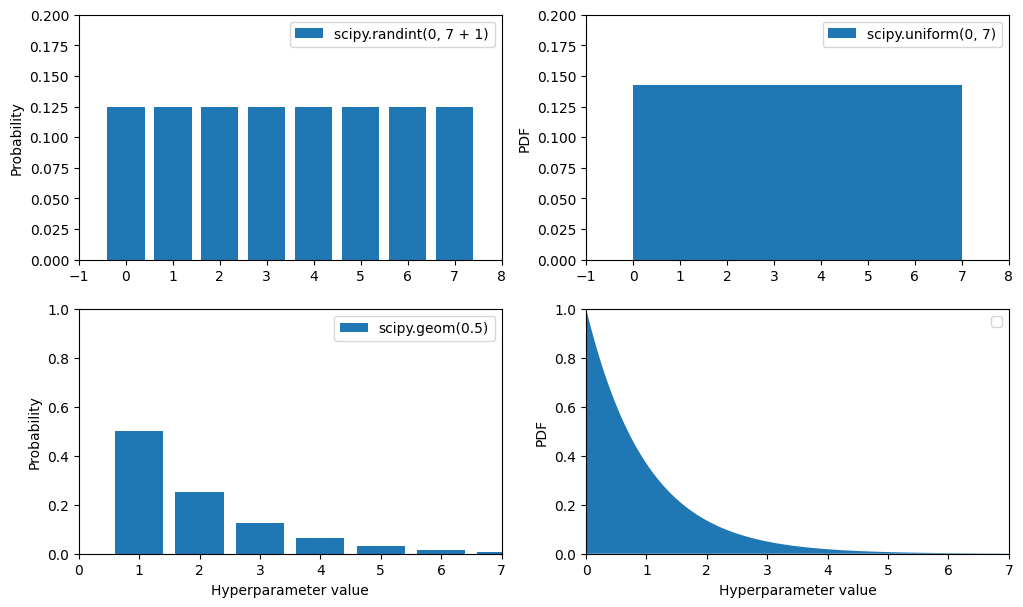

In [121]:
plt.figure(figsize = (12, 7))

plt.subplot(2,2,1)
plt.bar(xs1, randint_distrib, label = "scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2,2,2)
plt.fill_between(xs2, uniform_distrib, label = "scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2,2,3)
plt.bar(xs3, geom_distrib, label = "scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2,2,4)
plt.fill_between(xs4, expon_distrib)
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0,7, 0, 1])

plt.show()


In [122]:
cv_res_alt = pd.DataFrame(grid_search.cv_results_)
cv_res_alt.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res_alt = cv_res_alt.rename(columns={
    "param_preprocessing__geo__n_clusters": "n_cluster",
    "param_random_forest__max_features": "max_features",
    "split0_test_score": "split0",
    "split1_test_score": "split1",
    "split2_test_score": "split2",
    "mean_test_score": "mean_test_rmse"
})

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res_alt[score_cols] = -cv_res_alt[score_cols].round().astype(np.int64)

cv_res_alt = cv_res_alt[["n_cluster", "max_features"] + score_cols]

cv_res_alt.head()

,n_cluster,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42731,43308,44318,43452
13,15,8,43205,43959,44689,43951
6,10,4,43334,44191,44573,44032
9,10,6,43617,44126,44771,44171
7,10,6,43617,44126,44771,44171


In [123]:
cv_res_alt.head()

,n_cluster,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42731,43308,44318,43452
13,15,8,43205,43959,44689,43951
6,10,4,43334,44191,44573,44032
9,10,6,43617,44126,44771,44171
7,10,6,43617,44126,44771,44171


## Ensemble methods part of the book

In [124]:
final_model = rnd_search.best_estimator_
final_model

,steps,"[('preprocessing', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [125]:
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.08, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.01,
       0.02, 0.  , 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.04, 0.01, 0.01, 0.01, 0.02, 0.02,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.  , 0.06,
       0.  , 0.  , 0.  , 0.01, 0.04])

In [126]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse = True)

[(np.float64(0.18045439948466174), 'log__median_income'),
 (np.float64(0.07626182346865128), 'bedrooms__ratio'),
 (np.float64(0.06229237242089395), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.04826027796765376), 'people_per_house__ratio'),
 (np.float64(0.04749779851948902), 'rooms_per_house__ratio'),
 (np.float64(0.04320512414234371), 'remainder__Max cluster similarity'),
 (np.float64(0.036828433105354004), 'geo__Cluster 30 similarity'),
 (np.float64(0.02315737087156603), 'geo__Cluster 25 similarity'),
 (np.float64(0.019511430106210415), 'geo__Cluster 36 similarity'),
 (np.float64(0.0183362191856347), 'geo__Cluster 9 similarity'),
 (np.float64(0.01725663576617281), 'geo__Cluster 3 similarity'),
 (np.float64(0.016424953749126326), 'geo__Cluster 18 similarity'),
 (np.float64(0.016238942820576203), 'geo__Cluster 35 similarity'),
 (np.float64(0.015292388491208677), 'geo__Cluster 34 similarity'),
 (np.float64(0.014774289580557012), 'geo__Cluster 0 similarity'),
 (np.float64(0.01380888893

In [127]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [128]:
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,NEAR BAY


In [129]:
y_test.head()

3905     397700.0
16821    202900.0
2900     310000.0
7193     314300.0
13928    187500.0
Name: median_house_value, dtype: float64

In [130]:
# final_model.get_feature_names_out()

# Evaluating on the test set

In [131]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()


In [132]:
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,NEAR BAY


ADDING THE MAX CLUSTER SIMILARITY COLUMN TO X_TEST

In [133]:
test_similarities = cluster_simil.fit_transform(X_test[['latitude', 'longitude']], sample_weight = y_test)

In [134]:
test_similarities[:3].round(2)

array([[0.12, 0.  , 0.98, 0.  , 0.  , 0.  , 0.08, 0.  , 0.01, 0.58],
       [0.  , 0.97, 0.  , 0.01, 0.18, 0.  , 0.  , 0.84, 0.  , 0.  ],
       [0.  , 0.87, 0.  , 0.01, 0.16, 0.  , 0.  , 0.86, 0.  , 0.  ]])

In [135]:
X_test["Max cluster similarity"] = test_similarities.max(axis = 1)

In [136]:
# housing.head()

In [137]:
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,Max cluster similarity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,<1H OCEAN,0.982363
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,<1H OCEAN,0.967127
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,NEAR OCEAN,0.870775
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,NEAR OCEAN,0.965739
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,NEAR BAY,0.990769


In [138]:
# y_test.head()

In [139]:
# strat_test_set.head()

In [140]:
final_predictions = final_model.predict(X_test)

In [141]:
final_rmse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_rmse)
print(final_rmse)

41806.91086805669


In [142]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([39653.10266626, 43855.06859644])

In [143]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [144]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
      self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
      self.kmeans_.fit(X, sample_weight=sample_weight)
      return self

  def transform(self, X):
      return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
      return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
  
final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[::5] #pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [145]:
predictions

array([433818.11, 100911.  ,  62266.  , ..., 259416.  , 422100.13,
       491701.93], shape=(3303,))

In [146]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,Max cluster similarity
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428,0.842052
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936,0.217411
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000072
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500,0.821959
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500,0.935910
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000,0.973630
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,0.999996
